### Imports


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Carregando dados

In [6]:
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
sample_submission = pd.read_csv("sample_submission.csv")
train_maio_2017 = train[
    (train['date'].dt.year == 2017) & (train['date'].dt.month == 5)
]

### Médias móveis

In [7]:
def SMA(series, window):
    return series.rolling(window=window).mean()

def WMA(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

def EMA(series, span):
    return series.ewm(span=span, adjust=False).mean()

# Selecione a serie
store_id = 2
item_id = 2

series = (
    train_maio_2017[(train_maio_2017['store']==store_id) & (train_maio_2017['item']==item_id)]
    .sort_values('date')
    .set_index('date')['sales']
)
# Calculo de médias
df = pd.DataFrame({
    'sales': series,
    'SMA_3': SMA(series, 3),
    'SMA_7': SMA(series, 7),
    'SMA_14': SMA(series, 14),
    'WMA_7': WMA(series, 7),
    'EMA_7': EMA(series, 7),
})

### Gráfico 1 — SMA

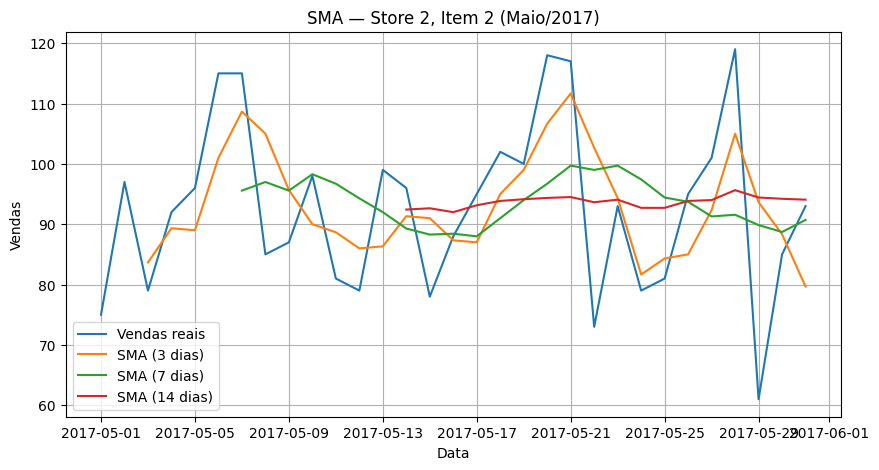

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['sales'], label='Vendas reais')
plt.plot(df.index, df['SMA_3'], label='SMA (3 dias)')
plt.plot(df.index, df['SMA_7'], label='SMA (7 dias)')
plt.plot(df.index, df['SMA_14'], label='SMA (14 dias)')
plt.title(f"SMA — Store {store_id}, Item {item_id} (Maio/2017)")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.legend()
plt.grid(True)
plt.show()

### Gráfico 2 — SMA vs WMA vs EMA

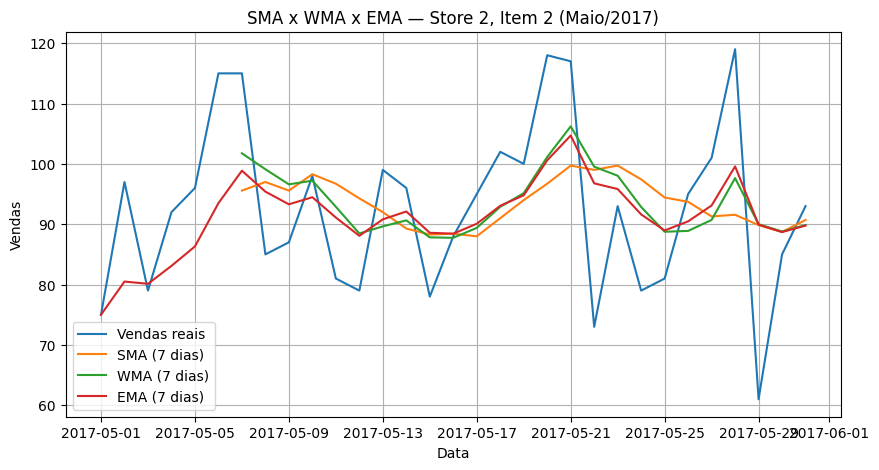

In [9]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['sales'], label='Vendas reais')
plt.plot(df.index, df['SMA_7'], label='SMA (7 dias)')
plt.plot(df.index, df['WMA_7'], label='WMA (7 dias)')
plt.plot(df.index, df['EMA_7'], label='EMA (7 dias)')
plt.title(f"SMA x WMA x EMA — Store {store_id}, Item {item_id} (Maio/2017)")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.legend()
plt.grid(True)
plt.show()

### Baselines


In [10]:
# Baselines (curto prazo)
test_size = 7
train_series = series.iloc[:-test_size]
test_series = series.iloc[-test_size:]

# Baseline constante (última SMA7)
last_sma7 = SMA(train_series, 7).iloc[-1]
const_forecast = np.full(test_size, last_sma7)

# Baseline linear (reta sobre SMA14)
sma14_train = SMA(train_series, 14)
trend_slice = sma14_train.dropna()
x = np.arange(len(trend_slice))
y = trend_slice.values
a, b = np.polyfit(x, y, 1)
future_x = np.arange(len(trend_slice), len(trend_slice)+test_size)
linear_forecast = a*future_x + b

# Métricas
actual = test_series.values
mae_const = mean_absolute_error(actual, const_forecast)
rmse_const = np.sqrt(mean_squared_error(actual, const_forecast))
mae_lin = mean_absolute_error(actual, linear_forecast)
rmse_lin = np.sqrt(mean_squared_error(actual, linear_forecast))




### Gráfico de previsão


📊 MÉTRICAS DE ERRO — MAIO/2017
                    Método        MAE       RMSE
0  Constante (última SMA7)  13.897959  17.948339
1           Linear (SMA14)  12.927644  17.136451


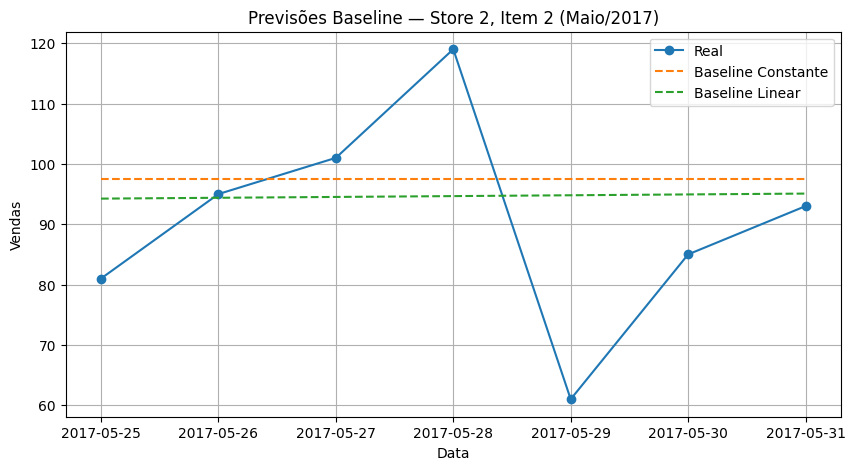

In [11]:
print("\n📊 MÉTRICAS DE ERRO — MAIO/2017")
print(pd.DataFrame({
    'Método': ['Constante (última SMA7)', 'Linear (SMA14)'],
    'MAE': [mae_const, mae_lin],
    'RMSE': [rmse_const, rmse_lin]
}))

plt.figure(figsize=(10,5))
plt.plot(test_series.index, actual, label="Real", marker='o')
plt.plot(test_series.index, const_forecast, label="Baseline Constante", linestyle='--')
plt.plot(test_series.index, linear_forecast, label="Baseline Linear", linestyle='--')
plt.title(f"Previsões Baseline — Store {store_id}, Item {item_id} (Maio/2017)")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.legend()
plt.grid(True)
plt.show()